In [229]:
# pip3 install pandas numpy scikit-learn lightgbm xgboost matplotlib seaborn torch 

In [262]:
import pandas as pd
import os
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [231]:
data = pd.read_csv("data/train.csv")

In [232]:
data.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


In [233]:
data.describe()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,loan_paid_back
count,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000
mean,296996.500000,48212.202976,0.120696,680.916009,15020.297629,12.356345,0.798820
std,171471.442236,26711.942078,0.068573,55.424956,6926.530568,2.008959,0.400883
min,0.000000,6002.430000,0.011000,395.000000,500.090000,3.200000,0.000000
25%,148498.250000,27934.400000,0.072000,646.000000,10279.620000,10.990000,1.000000
50%,296996.500000,46557.680000,0.096000,682.000000,15000.220000,12.370000,1.000000
75%,445494.750000,60981.320000,0.156000,719.000000,18858.580000,13.680000,1.000000
max,593993.000000,393381.740000,0.627000,849.000000,48959.950000,20.990000,1.000000


In [234]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    593994 non-null  int64  
 1   annual_income         593994 non-null  float64
 2   debt_to_income_ratio  593994 non-null  float64
 3   credit_score          593994 non-null  int64  
 4   loan_amount           593994 non-null  float64
 5   interest_rate         593994 non-null  float64
 6   gender                593994 non-null  object 
 7   marital_status        593994 non-null  object 
 8   education_level       593994 non-null  object 
 9   employment_status     593994 non-null  object 
 10  loan_purpose          593994 non-null  object 
 11  grade_subgrade        593994 non-null  object 
 12  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 58.9+ MB


In [235]:
data.shape

(593994, 13)

# Encoding

In [241]:
df_dtypes = data.dtypes

numerical_columns = data.select_dtypes(include=np.number).columns.tolist()
categorical_cols = data.select_dtypes(exclude=np.number).columns.tolist()

numerical_df_dtypes = df_dtypes[numerical_columns]
categorical_df_dtypes = df_dtypes[categorical_cols]

numerical_df = data[numerical_columns]
categorical_df = data[categorical_cols]

print("Number of numerical columns: ", len(numerical_df_dtypes))
print("Number of categorical columns: ", len(categorical_df_dtypes))

Number of numerical columns:  593994
Number of categorical columns:  593994


In [237]:
is_null = data.isnull().sum()
print(is_null)

id                      0
annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
gender                  0
marital_status          0
education_level         0
employment_status       0
loan_purpose            0
grade_subgrade          0
loan_paid_back          0
dtype: int64


In [238]:
data = data.drop(columns=["id"])
print(data.shape)

(593994, 12)


In [239]:
duplicates = data.duplicated().sum()
print(duplicates)

0


In [242]:
outlier_cols = numerical_df.drop(columns=["loan_paid_back"])

outlier_info = {}

for col in outlier_cols:
    Q1 = numerical_df[col].quantile(0.25)
    Q3 = numerical_df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    count_lower = (numerical_df[col] < lower).sum()
    count_upper = (numerical_df[col] > upper).sum()

    outlier_info[col] = {
        "lower_bound": lower,
        "upper_bound": upper, 
        "below_outliers": count_lower, 
        "above_outliers": count_upper
    }

data_top_drop = pd.DataFrame(outlier_info).T

In [206]:
print(data_top_drop)

                      lower_bound  upper_bound  below_outliers  above_outliers
annual_income          -21635.980   110551.700             0.0         15917.0
debt_to_income_ratio       -0.054        0.282             0.0         17556.0
credit_score              536.500      828.500          4065.0          1836.0
loan_amount             -2588.820    31727.020             0.0          2902.0
interest_rate               6.955       17.715          1966.0          3170.0


In [243]:
data_clipped = data.copy()

clip_counts = {}

for col in outlier_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    below_clip = (data[col] < lower).sum()
    above_clip = (data[col] > upper).sum()

    clip_counts[col] = {"clipped_below": below_clip, "clipped_above": above_clip}

    data_clipped[col] = data[col].clip(lower, upper)

clip_counts_df = pd.DataFrame(clip_counts).T
print(clip_counts_df)

                      clipped_below  clipped_above
annual_income                     0          15917
debt_to_income_ratio              0          17556
credit_score                   4065           1836
loan_amount                       0           2902
interest_rate                  1966           3170


In [244]:
data_he = pd.get_dummies(data_clipped, columns=["gender", "marital_status", "education_level", "employment_status", "loan_purpose", "grade_subgrade"], dtype=int)
data_he.to_csv("data/encoded_train.csv")
print(data_he.shape)

(593994, 61)


In [245]:
data_le = data_clipped.copy()

for col in categorical_cols:
    le = LabelEncoder()
    data_le[col] = le.fit_transform(data_le[col])

In [246]:
print(len(data_he.columns.tolist()))
print(data_he.columns)

61
Index(['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount',
       'interest_rate', 'loan_paid_back', 'gender_Female', 'gender_Male',
       'gender_Other', 'marital_status_Divorced', 'marital_status_Married',
       'marital_status_Single', 'marital_status_Widowed',
       'education_level_Bachelor's', 'education_level_High School',
       'education_level_Master's', 'education_level_Other',
       'education_level_PhD', 'employment_status_Employed',
       'employment_status_Retired', 'employment_status_Self-employed',
       'employment_status_Student', 'employment_status_Unemployed',
       'loan_purpose_Business', 'loan_purpose_Car',
       'loan_purpose_Debt consolidation', 'loan_purpose_Education',
       'loan_purpose_Home', 'loan_purpose_Medical', 'loan_purpose_Other',
       'loan_purpose_Vacation', 'grade_subgrade_A1', 'grade_subgrade_A2',
       'grade_subgrade_A3', 'grade_subgrade_A4', 'grade_subgrade_A5',
       'grade_subgrade_B1', 'grade_subgrade_B

Heatmap

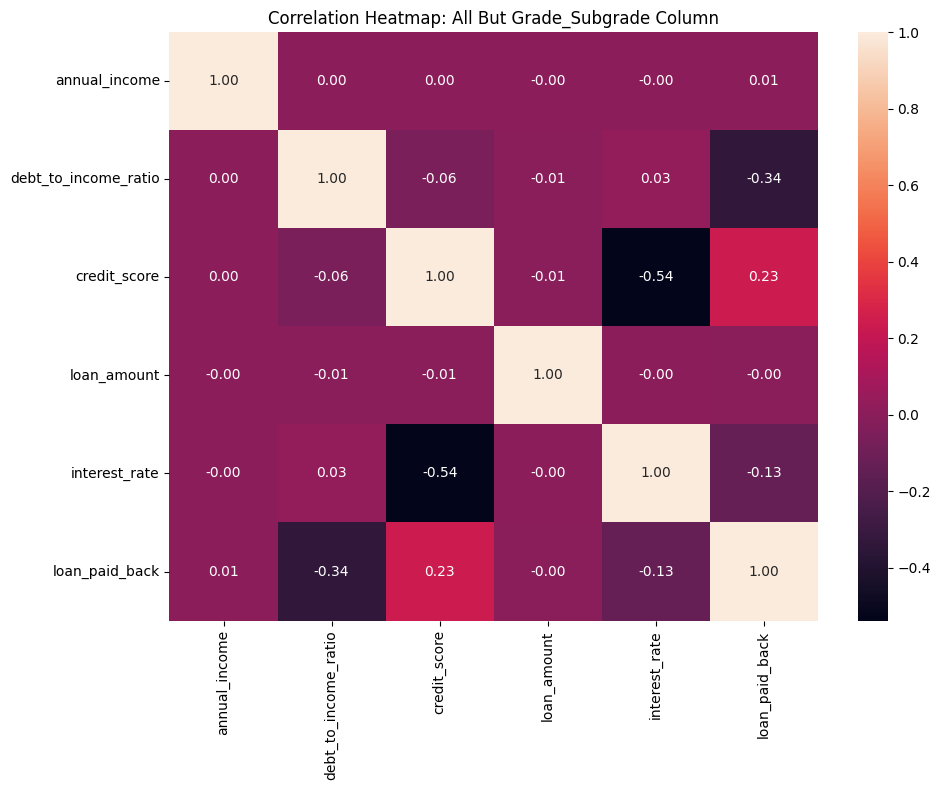

In [247]:
corr = data.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt = '.2f')
plt.title("Correlation Heatmap: All But Grade_Subgrade Column")
plt.tight_layout()
plt.savefig("images/correlation_heatmap_no_grade.png")
plt.show()

annual income and loan amount have no corrrelation to the target column "loan-paid-back", so they must be dropped

In [248]:
data = data.drop(columns=["annual_income", "loan_amount"])

# Training the Model

In [249]:
x = data_clipped.drop(columns=["loan_paid_back"])
y = data_clipped["loan_paid_back"]

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=20, test_size=0.2)

In [250]:
x_le = data_le.drop(columns=["loan_paid_back"])
y_le = data_le["loan_paid_back"]

scaler_le = StandardScaler()
x_scaled_le = scaler_le.fit_transform(x_le)

x_train_le, x_test_le, y_train_le, y_test_le = train_test_split(x_scaled_le, y_le, random_state=20, test_size=0.2)

In [251]:
x_he = data_he.drop(columns=["loan_paid_back"])
y_he = data_he["loan_paid_back"]

scaler_he = StandardScaler()
x_scaled_he = scaler_he.fit_transform(x_he)

x_train_he, x_test_he, y_train_he, y_test_he = train_test_split(x_scaled_he, y_he, random_state=20, test_size=0.2)

In [252]:
# Logistic Regression

lr = LogisticRegression(max_iter=1000)
lr.fit(x_train_he, y_train_he)
y_pred_lr = lr.predict(x_test_he)
print("Accuracy: ", accuracy_score(y_pred_lr, y_test_he)*100, "%")
print(f"Precision: {precision_score(y_pred_lr, y_test_he)}")
print(f"Recall Score: {recall_score(y_pred_lr, y_test_he)}")
print(f"F1 Score: {f1_score(y_pred_lr, y_test_he)}")
print(f"confusion Matrix: \n {confusion_matrix(y_pred_lr, y_test_he)}")

Accuracy:  90.12197072365929 %
Precision: 0.9743957632214708
Recall Score: 0.9084489033146455
F1 Score: 0.9402674349355337
confusion Matrix: 
 [[14702  2427]
 [ 9308 92362]]


In [255]:
# Decision Tree Classifier

tree = DecisionTreeClassifier(random_state=42)
tree.fit(x_train_le, y_train_le)
y_pred_tree = tree.predict(x_test_le)
print("Accuracy: ", accuracy_score(y_pred_tree, y_test_le)*100, "%")
print(f"Precision: {precision_score(y_pred_tree, y_test_le)}")
print(f"Recall Score: {recall_score(y_pred_tree, y_test_le)}")
print(f"F1 Score: {f1_score(y_pred_tree, y_test_le)}")
print(f"confusion Matrix: \n {confusion_matrix(y_pred_tree, y_test_le)}")

Accuracy:  84.89297047954949 %
Precision: 0.8996508033632594
Recall Score: 0.9099901826873826
F1 Score: 0.9047909560161485
confusion Matrix: 
 [[15575  9512]
 [ 8435 85277]]


In [256]:
# Random Forest Classifier

rf = RandomForestClassifier(random_state=42)
rf.fit(x_train_le, y_train_le)
y_pred_rf = rf.predict(x_test_le)
print("Accuracy: ", accuracy_score(y_pred_rf, y_test_le)*100, "%")
print(f"Precision: {precision_score(y_pred_rf, y_test_le)}")
print(f"Recall Score: {recall_score(y_pred_rf, y_test_le)}")
print(f"F1 Score: {f1_score(y_pred_rf, y_test_le)}")
print(f"Confusion Matrix: \n {confusion_matrix(y_pred_rf, y_test_le)}")


Accuracy:  90.25665199202012 %
Precision: 0.9789427043222315
Recall Score: 0.9064294924393389
F1 Score: 0.9412916347553523
Confusion Matrix: 
 [[14431  1996]
 [ 9579 92793]]


In [260]:
# Extra Trees Classifier

etree = ExtraTreesClassifier(n_estimators=100, random_state=42)
etree.fit(x_train_le, y_train_le)
y_pred_etree = etree.predict(x_test_le)

print("Accuracy: ", accuracy_score(y_pred_etree, y_test_le)*100, "%")
print(f"Precision: {precision_score(y_pred_etree, y_test_le)}")
print(f"Recall Score: {recall_score(y_pred_etree, y_test_le)}")
print(f"F1 Score: {f1_score(y_pred_etree, y_test_le)}")
print(f"Confusion Matrix: \n {confusion_matrix(y_pred_etree, y_test_le)}")

Accuracy:  90.1127113864595 %
Precision: 0.978953254069565
Recall Score: 0.9049100394948559
F1 Score: 0.9404765524440796
Confusion Matrix: 
 [[14259  1995]
 [ 9751 92794]]


In [259]:
# Gradient Boosting Classifier

gradboost = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gradboost.fit(x_train_he, y_train_he)
y_pred_grad = gradboost.predict(x_test_he)

print("Accuracy: ", accuracy_score(y_pred_grad, y_test_he)*100, "%")
print(f"Precision: {precision_score(y_pred_grad, y_test_he)}")
print(f"Recall Score: {recall_score(y_pred_grad, y_test_he)}")
print(f"F1 Score: {f1_score(y_pred_grad, y_test_he)}")
print(f"Confusion Matrix: \n {confusion_matrix(y_pred_grad, y_test_he)}")

Accuracy:  90.40059259758078 %
Precision: 0.9817805863549568
Recall Score: 0.9058098677230653
F1 Score: 0.9422664128629865
Confusion Matrix: 
 [[14333  1727]
 [ 9677 93062]]


In [257]:
# XGB Classifier

xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb.fit(x_train_le, y_train_le)
y_pred_xgb = xgb.predict(x_test_le)

print("Accuracy: ", accuracy_score(y_pred_xgb, y_test_le)*100, "%")
print(f"Precision: {precision_score(y_pred_xgb, y_test_le)}")
print(f"Recall Score: {recall_score(y_pred_xgb, y_test_le)}")
print(f"F1 Score: {f1_score(y_pred_xgb, y_test_le)}")
print(f"Confusion Matrix: \n {confusion_matrix(y_pred_xgb, y_test_le)}")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [00:13:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy:  90.37618161769039 %
Precision: 0.9824241209423035
Recall Score: 0.9050733793371561
F1 Score: 0.942163811026968
Confusion Matrix: 
 [[14243  1666]
 [ 9767 93123]]


In [258]:
# Light GBM Classifier

lgbm = LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
lgbm.fit(x_train_le, y_train_le)
y_pred_lgbm = lgbm.predict(x_test_le)

print("Accuracy: ", accuracy_score(y_pred_lgbm, y_test_le)*100, "%")
print(f"Precision: {precision_score(y_pred_lgbm, y_test_le)}")
print(f"Recall Score: {recall_score(y_pred_lgbm, y_test_le)}")
print(f"F1 Score: {f1_score(y_pred_lgbm, y_test_le)}")
print(f"Confusion Matrix: \n {confusion_matrix(y_pred_lgbm, y_test_le)}")

[LightGBM] [Info] Number of positive: 379705, number of negative: 95490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1321
[LightGBM] [Info] Number of data points in the train set: 475195, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.799051 -> initscore=1.380373
[LightGBM] [Info] Start training from score 1.380373
Accuracy:  90.52180573910555 %
Precision: 0.9824241209423035
Recall Score: 0.9065977394199597
F1 Score: 0.9429890737496582
Confusion Matrix: 
 [[14416  1666]
 [ 9594 93123]]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


# Model Ensemble 